# Случайный лес

> **Случайный лес (Random Forest)** — это самая распространённая реализация [бэггинга](./model_ensembles.ipynb), \
основанная на использовании в качестве базовой модели [дерева решений](./decision_trees.ipynb). 

Помимо бутстрэпа, случайный лес использует [метод случайных подпространств](https://en.wikipedia.org/wiki/Random_subspace_method). \
Суть его в том, что каждая модель обучается не на всех признаках, а только на части из них. \
Такой подход позволяет уменьшить коррелированность между ответами деревьев \
и сделать их независимыми друг от друга.

## Алгоритм построения случайного леса для задачи классификации

Пусть количество объектов в наборе данных равно N, а количество признаков — M. \
То есть размер набора данных — (N, M). \
Количество деревьев в лесу равно K. \
Тогда для обучения случайного леса необходимо выполнить следующие шаги:

1. С помощью бутстрэпа создать K наборов данных размера (N, M).
2. Для каждого сгенерированного набора данных применить метод случайных подпространств: \
выбрать L < M случайных признаков \
и получить K новых наборов данных размером (N, L).
3. На каждом наборе данных обучить дерево решений.

Когда поступят новые данные, нужно прогнать их через каждое дерево \
и объединить результаты отдельных деревьев мажоритарным голосованием \
или путём комбинирования вероятностей.

## Реализация в sklearn

В `sklearn` все ансамблевые методы реализованы в модуле `ensemble`.\
Модель случайного леса для решения задачи классификации реализована в классе [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

**Основные параметры RandomForestClassifier**

- `n_estimators` — количество деревьев в лесу \
(число K из бэггинга; по умолчанию равно `100`);
- `criterion` — критерий информативности разбиения для каждого из деревьев \
('`gini`' — критерий Джини и '`entropy`' — энтропия Шеннона; по умолчанию — '`gini`');
- `max_depth` — максимальная глубина одного дерева \
(по умолчанию — `None`, то есть глубина дерева не ограничена);
- `max_features` — максимальное число признаков, которые будут использоваться каждым из деревьев \
(число L из метода случайных подпространств; \
по умолчанию — '`sqrt`'; для обучения каждого из деревьев используется $\sqrt{m}$ признаков, \
где $m$ — число признаков в начальном наборе данных);
- `min_samples_leaf` — минимальное число объектов в листе (по умолчанию — `1`);
- `random_state` — параметр, отвечающий за генерацию случайных чисел.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn')

from warnings import simplefilter
simplefilter('ignore')

In [5]:
# загрузим данные об ирисах
iris_data = sns.load_dataset('iris')
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


`species` - вид ириса, целевой признак.

In [7]:
# факторы
X = iris_data.drop(columns=['species'])
# целевой признак
y = iris_data['species']

# разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# создаём объект класса RandomForestClassifier
random_forest_classifier_model = RandomForestClassifier(
    n_estimators=100, # число деревьев
    criterion='gini', # критерий эффективности
    max_depth=5, # максимальная глубина дерева
    min_samples_leaf=3, # минимальное число объектов в листе
    max_features='sqrt', # число признаков из метода случайных подпространств
    random_state=42 # генератор случайных чисел
)

# обучаем модель 
random_forest_classifier_model.fit(X_train, y_train)
 
# делаем предсказание класса
y_train_pred = random_forest_classifier_model.predict(X_train)
y_test_pred = random_forest_classifier_model.predict(X_test)

# выводим отчёт о метриках
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.97      0.95      0.96        40
   virginica       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



Вероятности каждого из классов можно получить с помощью метода `predict_proba`.

In [9]:
random_forest_classifier_model.predict_proba(X_test)[:5]

array([[1.        , 0.        , 0.        ],
       [0.        , 0.21853211, 0.78146789],
       [0.02211905, 0.908     , 0.06988095],
       [0.02211905, 0.90216667, 0.07571429],
       [1.        , 0.        , 0.        ]])

Коэффициенты значимости признаков можно получить из поля `feature_importances_`.

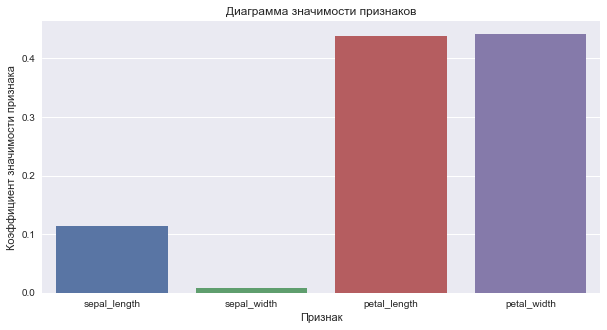

In [15]:
# фигура + координатная плоскость
fig, ax = plt.subplots(figsize=(10, 5)) 
# признаки
feature_names = X.columns 
# важность признаков
feature_importances = random_forest_classifier_model.feature_importances_ 

# строим столбчатую диаграмму
sns.barplot(x=feature_names, y=feature_importances, ax=ax);

# название графика и осей
ax.set_title('Диаграмма значимости признаков')
ax.set_xlabel('Признак')
ax.set_ylabel('Коэффициент значимости признака');